# Reddit sentiment during heatwaves
This notebook discusses the process that was used to investigate whether heatwaves have an impact on the sentiment of the post within investment related subreddits.

### Loading required packages

In [1]:
# Classes defined by group
from RedditData import RedditData # Used to easily scrape reddit data


# Other required packages
import pandas as pd
import numpy as np
import nltk
import yahoo_fin.stock_info as si
import matplotlib.pyplot as plt
from datetime import datetime

# Model
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Obtain heatwave data

To determine when a heatwave occurs, we scrape posts in the major news subreddits on the keyword heatwave. We assume that a heatwave is happening when heatwaves are discussed in these subreddits. The years 2018 and 2019 are investigated.

In [2]:
start = '2018/1/1'
stop = '2020/1/1'

Start and stop dates for our search, we want to see the heatwaves in the usa in 2018 and in europe in 2019

In [3]:
stories = RedditData() # Using the pre-made class
subreddits = ['news','worldnews','TrueNews', "InDepthStories"]
keywords =  ["heat wave"]
stories.collect(subreddits, keywords, start,stop, 'submission', '>9').head(2)

,Search Term,author,subreddit,created_utc,full_link,id,is_self,is_video,locked,num_comments,num_crossposts,pinned,score,selftext,title
0,heat wave,Klee_Irwin,news,1515514753,https://www.reddit.com/r/news/comments/7p84mc/...,7p84mc,False,False,False,20,0,False,44,,Hundreds of 'Boiled' Bats Fall from Sky in Aus...
1,heat wave,AvailableWrongdoer,news,1522091234,https://www.reddit.com/r/news/comments/87bqxi/...,87bqxi,False,False,False,3,0,False,31,,"India: Delhi, Mumbai and Kolkata on alert for ..."


The plot below indicates when the posts related to heatwaves are made.

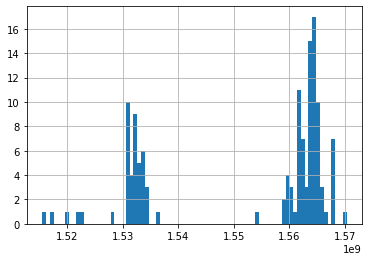

In [4]:
stories.dataframe['created_utc'].hist(bins = 80);

Using the histogram as defined above we can estimate the heatwave locations by placing them below/above a cutoff value of our chosing. The cut-off value was decided to be equal to 10.

In [5]:
# Obtain histogram values
counts, rEdge = np.histogram(stories.dataframe['created_utc'], bins = 80)
cutoff = 10
intervals = []
for i in range(len(counts)):
    if counts[i] >= cutoff:
        intervals.append((rEdge[i],rEdge[i+1]))
intervals

[(1530569906.575, 1531254231.7375),
 (1561364538.8875, 1562048864.05),
 (1563417514.375, 1564101839.5375),
 (1564101839.5375, 1564786164.7),
 (1564786164.7, 1565470489.8625)]

Intervals containing heatwaves defined using the histogram are shown above.  We will be able to check easily if a timestamp lies inside one of these intervals to flag it as being a stock/sentiment which was produced during a heatwave or not.

In [6]:
def heat(x, intervals):
    for edge in intervals:
        if (x >= edge[0]) & (x <= edge[1]):
            return 1
    return 0

### Obtain sentiment data
In order to estimate investor sentiment, we make use of *sentiment analysis* on the post in investing related subreddits. First, the posts in these subreddits need to be scraped.

In [7]:
sublist = ['stocks', 'investing','superstonk','stockmarket']
stories.collect(sublist, ['*'],  start,stop, 'submission', '>49').sample(2)

,Search Term,author,subreddit,created_utc,full_link,id,is_self,is_video,locked,num_comments,num_crossposts,pinned,score,selftext,title
63,*,netflixnagger,stocks,1552380264,https://www.reddit.com/r/stocks/comments/b05ft...,b05ftj,True,False,False,50,0,False,89,High dividend stock that is pretty undervalued...,What do you all think of Altria Group (MO)?
77,*,coolcomfort123,investing,1565783745,https://www.reddit.com/r/investing/comments/cq...,cq8moo,True,False,False,41,0,False,134,https://www.cnbc.com/2019/08/13/us-bonds-yield...,Main yield curve inverts as 2-year yield tops ...


Here we gather submissions from several subreddits in an attempt to estimate the overall sentiment about the stock.  Comments contain more information but not necessarily about the stock itself, and so they can lead to a less useful model.

In [8]:
stockstories = stories.dataframe[stories.getdata()['Search Term'] != "heat wave"]

In [9]:
times = stockstories['created_utc']
# Indicate whether story was posted during a heatwave
tSeries = stockstories['created_utc'].apply(lambda x: heat(x, intervals))
pd.DataFrame({'Times': pd.to_datetime(times, unit = 's'), 'Heatwave' : tSeries}).head()

,Times,Heatwave
0,2018-01-02 14:40:06,0
1,2018-01-03 16:13:26,0
2,2018-01-03 22:49:12,0
3,2018-01-04 04:56:18,0
4,2018-01-04 18:41:20,0


In [10]:
# Merge heatwave and stockstories dataset
df_sentiment = stockstories[['title','created_utc', 'subreddit']]
heat_utc = pd.DataFrame({'created_utc': times, 'Heatwave' : tSeries})
df_sentiment = pd.merge(df_sentiment, heat_utc)
df_sentiment['Date'] = pd.to_datetime(df_sentiment['created_utc'], unit = 's').apply(lambda x: x.date())
df_sentiment = df_sentiment.drop(columns = 'created_utc')
df_sentiment.head()

,title,subreddit,Heatwave,Date
0,Citibank : 40% probability of Apple buying Net...,stocks,0,2018-01-02
1,"Spotify reportedly filed for its IPO, thoughts?",stocks,0,2018-01-03
2,How I feel every time I close out a profitable...,stocks,0,2018-01-03
3,Friendly Reminder,stocks,0,2018-01-04
4,Intel Insider Trading,stocks,0,2018-01-04


###### Perform the actual sentiment analysis
First we download the necessary files.

In [11]:
nltk.download('vader_lexicon');

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Gebruiker\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Initiate the model and apply it on all the titles.

In [12]:
vds = SentimentIntensityAnalyzer()
df_sentiment['sentiment'] = df_sentiment['title'].apply(lambda x: vds.polarity_scores(x)['compound'])
df_sentiment.head()

,title,subreddit,Heatwave,Date,sentiment
0,Citibank : 40% probability of Apple buying Net...,stocks,0,2018-01-02,0.0000
1,"Spotify reportedly filed for its IPO, thoughts?",stocks,0,2018-01-03,0.0000
2,How I feel every time I close out a profitable...,stocks,0,2018-01-03,0.4404
3,Friendly Reminder,stocks,0,2018-01-04,0.4939
4,Intel Insider Trading,stocks,0,2018-01-04,0.0000


In [13]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Gebruiker\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Obtain stock data
To check whether the sentiment affects the stock prices we make use of history S&P data.

In [14]:
stocksinfo = si.get_data('SPY', start_date = start, end_date = stop)['adjclose']

In [15]:
df_stocksinfo = pd.DataFrame({'Close':stocksinfo, 'Date': stocksinfo.index})
df_stocksinfo.head()

,Close,Date
2018-01-02,253.283142,2018-01-02
2018-01-03,254.885162,2018-01-03
2018-01-04,255.959488,2018-01-04
2018-01-05,257.665283,2018-01-05
2018-01-08,258.136414,2018-01-08


## Put everything together
In this section, we create the plots that summarize all data obtained so far. First, we aggregate the sentiment data such that we have a single sentiment score per day.

In [16]:
df_sentiment = df_sentiment.sort_values(by = 'Date')
aggregate_sentiment = []
days = df_sentiment['Date'].unique()
for i,e in enumerate(days):
    toadd = df_sentiment[df_sentiment['Date'] == e]['sentiment'].sum()
    aggregate_sentiment.append(toadd)
ag_sent_data = pd.DataFrame({'Date': days, 'sentiment':aggregate_sentiment})
ag_sent_data.head()

,Date,sentiment
0,2018-01-01,-0.1321
1,2018-01-02,0.6369
2,2018-01-03,0.6908
3,2018-01-04,0.8026
4,2018-01-05,1.4078


Now, we merge the datasets:

In [17]:
ag_sent_data['Date'] = pd.to_datetime(ag_sent_data['Date'])
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'])
df_stocks_sentiment = pd.merge(df_stocksinfo, ag_sent_data, on = 'Date').sort_values(by = 'Date')
df_stocks_sentiment.head()

,Close,Date,sentiment
0,253.283142,2018-01-02,0.6369
1,254.885162,2018-01-03,0.6908
2,255.959488,2018-01-04,0.8026
3,257.665283,2018-01-05,1.4078
4,258.136414,2018-01-08,0.7888


In [18]:
hwaves = (df_stocks_sentiment['Date'].astype(np.int64)/10**9).apply(lambda x: heat(x, intervals))
df_stocks_sentiment['Heat Wave'] = hwaves.to_numpy()
df_stocks_sentiment.head()

,Close,Date,sentiment,Heat Wave
0,253.283142,2018-01-02,0.6369,0
1,254.885162,2018-01-03,0.6908,0
2,255.959488,2018-01-04,0.8026,0
3,257.665283,2018-01-05,1.4078,0
4,258.136414,2018-01-08,0.7888,0


The following plot shows the distributions for sentiments during heatwaves and without heatwaves.

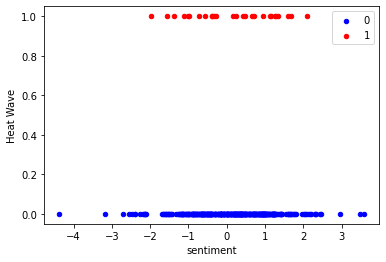

In [19]:
fig, ax = plt.subplots()

colors = {0:'blue',1:'red'}

grouped = df_stocks_sentiment.groupby('Heat Wave')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='sentiment', y = 'Heat Wave', label=key, color=colors[key])

plt.show()

Now, we focus on visualizing this link between heatwaves, stock price and sentiment. The heatwaves will be visualized by red squares for which we need to capture the leading and following edges.

In [20]:
hws = df_stocks_sentiment['Heat Wave']#np.where(df_stocks_reduced['Heat Wave'] == 1)
leading_edges = []
following_edges = []
for i in range(len(hws)):
    if hws[i] == 1:
        if i == 0:
            leading_edges.append(i)
        elif hws[i-1] == 0 :
            leading_edges.append(i)
        
    if hws[i] == 0 :
        if i != 0:
            if hws[i-1] == 1 :
                following_edges.append(i)
                
if len(leading_edges) != len(following_edges):
    if min(leading_edges) > min(following_edges):
        leading_edges = [0] + leading_edges
        
    if max(leading_edge) > max(following_edges):
        following_edges = following_edges + [len(hws)]

Next, the data is split up between 2018 and 2019.

In [21]:
df_stocks_sentiment.index = pd.to_datetime(df_stocks_sentiment['Date'])
df_stocks_sentiment_2018 = df_stocks_sentiment[df_stocks_sentiment.Date < pd.to_datetime(datetime(2019,1,1).date())]
df_stocks_sentiment_2018 = df_stocks_sentiment_2018.iloc[:-1]
df_stocks_sentiment_2019 = df_stocks_sentiment[df_stocks_sentiment.Date >= pd.to_datetime(datetime(2019,1,1).date())]
df_stocks_sentiment_2019 = df_stocks_sentiment_2019.iloc[:-1]

leading_edges_2018 = [edge for edge in leading_edges if edge < len(df_stocks_sentiment_2018)]
following_edges_2018 = [edge for edge in following_edges if edge < len(df_stocks_sentiment_2018)]

leading_edges_2019 = [edge for edge in leading_edges if edge not in leading_edges_2018]
following_edges_2019 = [edge for edge in following_edges if edge not in following_edges_2018]

Generating the plots:

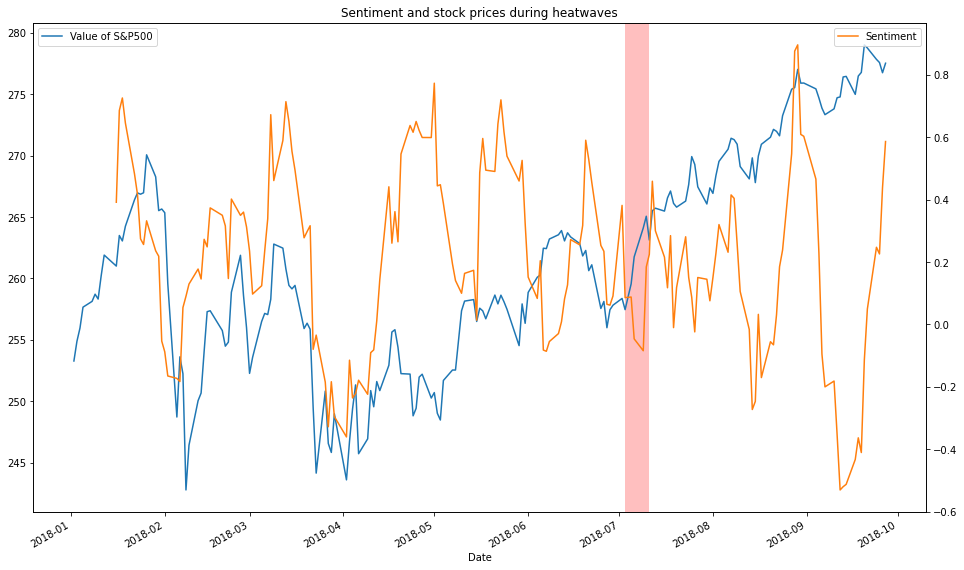

In [22]:
df_stocks_sentiment_2018.loc[:, "Value of S&P500"] = df_stocks_sentiment_2018['Close']
ax = df_stocks_sentiment_2018["Value of S&P500"].plot(x = 'Date', figsize = (16,10), title="Sentiment and stock prices during heatwaves")
for i,j in zip(df_stocks_sentiment['Date'].iloc[leading_edges_2018], df_stocks_sentiment['Date'].iloc[following_edges_2018]):
    ax.axvspan(i,j, facecolor = 'red', alpha= 0.25)
    
df_stocks_sentiment_2018['Sentiment'] = df_stocks_sentiment_2018['sentiment'].rolling(10).mean()
df_stocks_sentiment_2018['Sentiment'].plot(x = "Date", secondary_y = True)
plt.legend()
ax.legend();

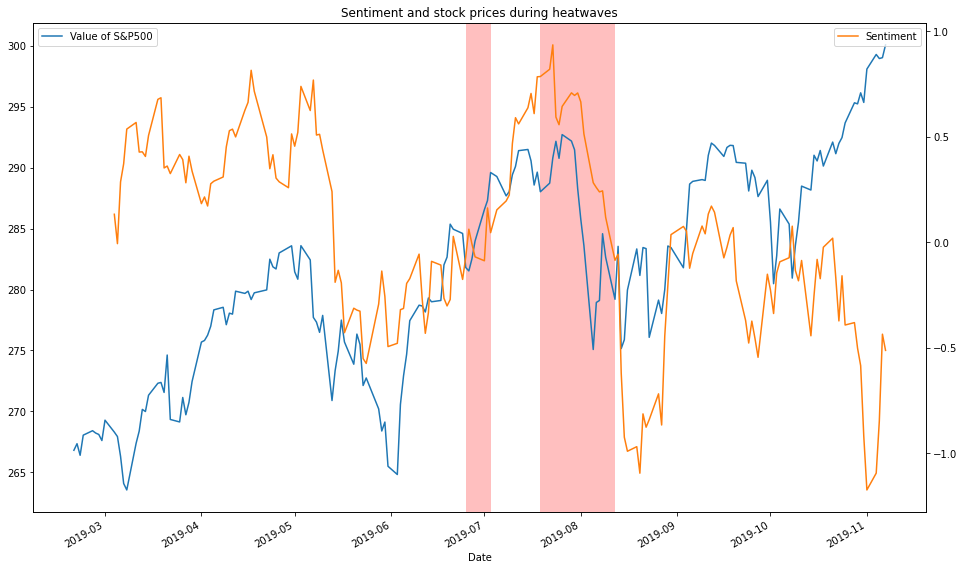

In [23]:
df_stocks_sentiment_2019.loc[:, "Value of S&P500"] = df_stocks_sentiment_2019['Close']
ax = df_stocks_sentiment_2019["Value of S&P500"].plot(x = 'Date', figsize = (16,10), title="Sentiment and stock prices during heatwaves")
for i,j in zip(df_stocks_sentiment['Date'].iloc[leading_edges_2019], df_stocks_sentiment['Date'].iloc[following_edges_2019]):
    ax.axvspan(i,j, facecolor = 'red', alpha= 0.25)
    
df_stocks_sentiment_2019['Sentiment'] = df_stocks_sentiment_2019['sentiment'].rolling(10).mean()
df_stocks_sentiment_2019['Sentiment'].plot(x = "Date", secondary_y = True)
plt.legend()
ax.legend();